In this project, we are going to examine synthetic credit card transactions and train a model to accurately predict whether a given transaction is fraudulent.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sqlite3

In [2]:
train_data = pd.read_csv('fraudTrain.csv')

In [3]:
train_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [125]:
train_data.groupby(['is_fraud']).size()
train_data.groupby(['cc_num']).size()

cc_num
60416207185            1518
60422928733            1531
60423098130             510
60427851591             528
60487002085             496
                       ... 
4958589671582726883    1476
4973530368125489546    1040
4980323467523543940     532
4989847570577635369    1007
4992346398065154184    2059
Length: 983, dtype: int64

This is a highly imbalanced dataset, with non-fraud data being more than 180 times of the fraud ones. On the other hand, reducing false negative rate is very important due to the business context. We will need to address it.

First of all, let's quickly build a logistic regression model and see where we can go after that.

In [4]:
train_data.drop(columns = ['Unnamed: 0', 'trans_date_trans_time',
       'first', 'last', 'street', 'city', 'state', 'dob',
       'trans_num'],inplace = True)

In [5]:
train_data.columns

Index(['cc_num', 'merchant', 'category', 'amt', 'gender', 'zip', 'lat', 'long',
       'city_pop', 'job', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

We will convert the categorical variables with one-hot encodings. There will be a huge amount of variables, but let's not worry about that for now.

In [6]:
def one_hot_convert(df, columns):
    
    for Col in columns:
        df = pd.concat([df, pd.get_dummies(df[Col], prefix = Col)], axis = 1)
    
    df.drop(columns = columns, inplace = True)
    
    return df

In [7]:
Cat_columns = ['merchant', 'category', 'gender','job']

train_data = one_hot_convert(train_data, Cat_columns)

In [130]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

The dataset is too big (1.16M-by-1211, resulting in 10.5GiB) to train if we use one-hot encoding without any restraint. There are several ways to solve it. We can decrease the precision, or we can choose fewer samples to begin with.

I should also create a new column calculating the distance between the cardholder's address and the merchant's.


In [9]:
df_Fraud = train_data[train_data['is_fraud'] == 1]
df_Non_fraud = train_data[train_data['is_fraud'] == 0]

n = df_Fraud.shape[0]

df_Non_fraud = df_Non_fraud.sample(n=n)

df_Non_fraud.shape

df_rest = train_data[train_data['is_fraud'] == 0].drop(df_Non_fraud.index)

df_rest.shape

(1281663, 1213)

In [10]:
little_dataset = pd.concat([df_Fraud,df_Non_fraud], axis = 0)
little_dataset = little_dataset.sample(frac = 1)
little_dataset.shape

(15012, 1213)

In [131]:
X = little_dataset.copy()
Y = little_dataset['is_fraud']
X.drop(columns = ['cc_num','is_fraud'], inplace = True)

scaler = StandardScaler()
scaler.fit(X)

X = scaler.transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
LR = LogisticRegression(max_iter = 1000)

LR.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [73]:
LR.score(X_test, y_test)

0.8275632490013316

In [46]:
y_pred = LR.predict(X_test)

confusion_matrix(y_pred,y_test)

array([[675, 157],
       [107, 563]], dtype=int64)

In [47]:
LR.score(X_train,y_train)

0.8729089563286454

Using logistic regression, the fitted model predicts horribly, even for the training set. The confusion matrix shows that most predictions are flagged as non-fraud. It suggests that it is hard to describe the final prediction with linear hyperplanes.

In [74]:
little_dataset['distance'] = np.sqrt(np.power(little_dataset['lat']- little_dataset['merch_lat'],2) + np.power(little_dataset['long']- little_dataset['merch_long'],2) )
little_dataset = little_dataset.sample(frac= 1)

In [12]:
X = little_dataset.copy()
Y = little_dataset['is_fraud']
X.drop(columns = ['is_fraud', 'cc_num'], inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
LR = LogisticRegression()

LR.fit(X_train,y_train)
LR.score(X_test, y_test)

0.4866844207723036

In [50]:
y_pred = LR.predict(X_test)

confusion_matrix(y_pred,y_test)

array([[736, 766],
       [  0,   0]], dtype=int64)

In [13]:
scaler = StandardScaler()
scaler.fit(X)

X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=42)
LR = LogisticRegression(max_iter =500)

LR.fit(X_train,y_train)
LR.score(X_test, y_test)

0.8428761651131824

In [105]:
y_pred = LR.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[619, 127],
       [141, 615]], dtype=int64)

I tried to use SVM to fit the data, but the process just takes too long. According to the documentation, it scales at least quadratically with respect to the number of samples and is impractical beyond tens of thousands of them. Our little dataset is right on the cusp, so I can see why things are not great here. Instead, we can either use the linear SVM or other models.

```python
svm = SVC()
svm.fit(X_train,y_train)
svm.score(X_test, y_test)
```

Let's first try to visualize our dataset a little bit. We can plot out the scatter plot of (amount, distance from cardholder address) and see if there are some relations we can exploit.

In [80]:
scatter_df = little_dataset[['amt','distance','is_fraud']]

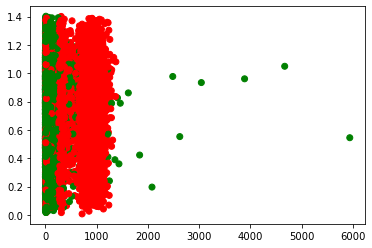

In [82]:
colors = ['red' if tag == 1 else 'green' for tag in scatter_df['is_fraud']]

plt.scatter(scatter_df['amt'], scatter_df['distance'], c = colors)

It looks like it is hard to make out whether the transaction is fraudulent from the distance. Interestingly, the very high transaction amount correlates to genuine transactions.

In [15]:
job_col = [col for col in little_dataset.columns if 'job' in col]
job_col[:5]

['job_Academic librarian',
 'job_Accountant, chartered',
 'job_Accountant, chartered certified',
 'job_Accountant, chartered public finance',
 'job_Accounting technician']

In [30]:
new_train_data = pd.read_csv('fraudTrain.csv')

job_analysis = new_train_data[['job','is_fraud']]

job_analysis.head()

,job,is_fraud
0,"Psychologist, counselling",0
1,Special educational needs teacher,0
2,Nature conservation officer,0
3,Patent attorney,0
4,Dance movement psychotherapist,0


In [20]:
job_df = job_analysis.groupby(['job']).mean()

In [27]:
trimmed_job_df = job_df[job_analysis.groupby(['job']).count()>50]

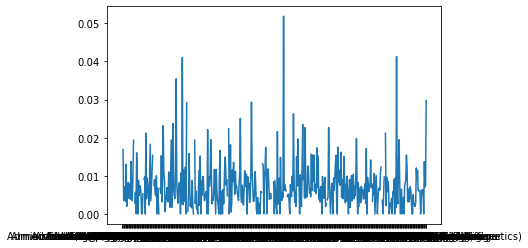

In [28]:
plt.plot(trimmed_job_df)

Here, we write a function to observe the influence of one single categorical variable on determining whether the transaction is fraudulent.

In [31]:
def check_category_correlation(df, col, threshold = None):
    col_df = df[[col,'is_fraud']]
    col_analysis = col_df.groupby([col]).mean()
    if threshold and type(threshold) == int:
        col_analysis = col_analysis[col_df.groupby([col]).count() > threshold]
    plt.plot(col_analysis)

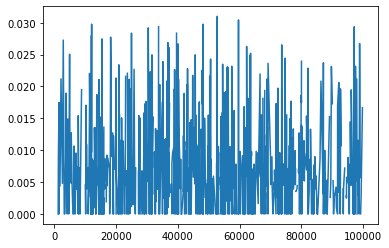

In [37]:
check_category_correlation(new_train_data, 'zip', threshold = 50)

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

We compute the ROC curve for logistic regression. By default, it plots the false positive rate against the true positive rate. Perhaps we should plot the true negative and false negative rate.

In [49]:
y_proba = LR.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1])

<class 'numpy.ndarray'>


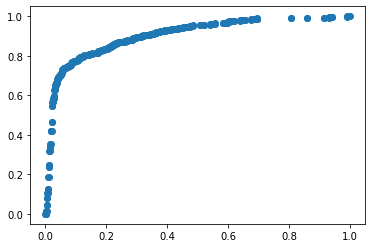

In [68]:
plt.scatter(fpr, tpr)

In [73]:
tnr, fnr = 1-fpr, 1-tpr

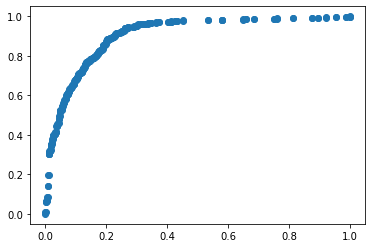

In [78]:
plt.scatter(fnr, tnr)

#plt.plot([0,0], [1,1], 'k-', color = 'r')

For what we care about (low false negative rate), logistic regression is not that good, as it climbs relatively slowly in the beginning.

In [15]:
feature_col = list(little_dataset.columns)
feature_col.remove('is_fraud')
feature_col.remove('cc_num')

rankings_LR = sorted(zip(feature_col, LR.coef_.reshape(1211)),key= lambda x: abs(x[1]), reverse = True)

In [16]:
rankings_LR[:10]

[('amt', 4.887603321244665),
 ('category_shopping_net', -0.7958979348139289),
 ('category_shopping_pos', -0.6945723440197848),
 ('category_health_fitness', 0.5292348400981515),
 ('job_Camera operator', -0.41761068492424136),
 ('category_gas_transport', 0.41269091942636377),
 ('job_Social research officer, government', -0.3262003659078845),
 ('job_Writer', 0.3222497451153598),
 ('category_personal_care', 0.3166823290749055),
 ('job_Therapist, sports', -0.3028148496350628)]

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [115]:
def random_testing(df, frac, model):
    smaller = df.sample(frac = frac)
    smaller_X = smaller.drop(columns = ['is_fraud', 'cc_num'])
    smaller_Y = smaller[['is_fraud']]
    smaller_X_transformed = scaler.transform(smaller_X)
    
    print(model.score(smaller_X_transformed, smaller_Y))
    
    Y_predict = model.predict(smaller_X_transformed)
    
    print(confusion_matrix(smaller_Y, Y_predict))
    
    
    y_proba = model.predict_proba(smaller_X_transformed)
    
    fpr, tpr, thresholds = roc_curve(smaller_Y, y_proba[:,1])
    
    plt.scatter(1-tpr, 1-fpr)
    


0.8414489311163895
[[108464  20449]
 [   110    645]]


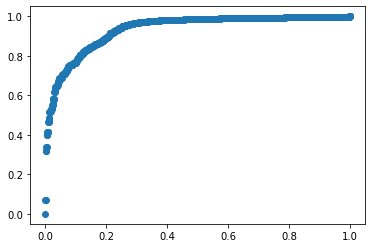

In [130]:
random_testing(train_data, 0.1, LR)

0.9506663170558658
[[122581   6397]
 [     0    690]]


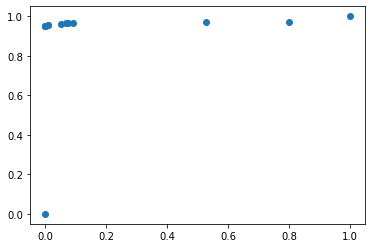

In [140]:
random_testing(train_data, 0.1, DTC)

From the confusion matrix above, we can see that when the dataset is imbalanced, the false negative rate is fine, but the number of flagged transactions are perhaps a bit high. Can we do a pipeline to re-evaluate those flagged transactions?

Also, it is possible that the very low false negative rate happens because we have already trained on most of the fraud data. Perhaps we should re-consider our random testing method. I have extracted the df_rest from the remaining non-fraud data. We should iteratively test all data and use the confusion matrix to sum up all the results. All the fraud entries are already in the test set, so we should utilize that.

In [148]:
rankings_DTC = sorted(zip(feature_col, DTC.feature_importances_.reshape(1211)),key= lambda x: abs(x[1]), reverse = True)

rankings_DTC[:10]

[('amt', 0.7324315644664732),
 ('category_gas_transport', 0.08057419546461565),
 ('category_grocery_net', 0.02375913780783269),
 ('category_travel', 0.015594658164946066),
 ('category_home', 0.014784477717247347),
 ('category_food_dining', 0.014418878834217535),
 ('category_misc_pos', 0.013018883694656631),
 ('city_pop', 0.010497054440302642),
 ('unix_time', 0.009884335727756141),
 ('category_shopping_net', 0.008190842344716434)]

[Text(261.26518250857424, 212.26285714285714, 'X[0] <= -0.166\ngini = 0.5\nsamples = 13510\nvalue = [6760, 6750]'),
 Text(206.384474522293, 201.90857142857143, 'X[0] <= -0.734\ngini = 0.322\nsamples = 8252\nvalue = [6585, 1667]'),
 Text(146.3519720725135, 191.5542857142857, 'X[703] <= 1.412\ngini = 0.461\nsamples = 3883\nvalue = [2485, 1398]'),
 Text(145.03967417932387, 181.2, 'X[0] <= -0.755\ngini = 0.378\nsamples = 3326\nvalue = [2485, 841]'),
 Text(101.3750122488976, 170.84571428571428, 'X[704] <= 2.939\ngini = 0.263\nsamples = 2571\nvalue = [2171, 400]'),
 Text(81.362469377756, 160.49142857142857, 'X[710] <= 2.126\ngini = 0.209\nsamples = 2458\nvalue = [2167, 291]'),
 Text(51.835766780989715, 150.13714285714286, 'X[714] <= 3.292\ngini = 0.137\nsamples = 2089\nvalue = [1934, 155]'),
 Text(23.621362077413032, 139.78285714285715, 'X[708] <= 1.851\ngini = 0.054\nsamples = 1831\nvalue = [1780, 51]'),
 Text(15.419500244977952, 129.42857142857144, 'X[1149] <= 11.758\ngini = 0.011\nsamples

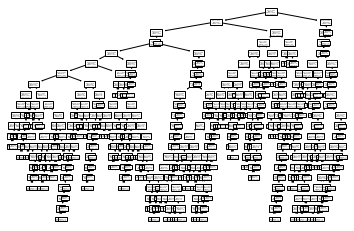

In [146]:
tree.plot_tree(DTC)

In [12]:
test_data = pd.read_csv('fraudTest.csv')
    

In [13]:
test_data.shape

(555719, 23)

In [14]:
test_data.drop(columns = ['Unnamed: 0', 'trans_date_trans_time',
       'first', 'last', 'street', 'city', 'state', 'dob',
       'trans_num'],inplace = True)

In [15]:
Cat_columns = ['merchant', 'category', 'gender','job']

test_data = one_hot_convert(test_data, Cat_columns)

In [16]:
test_data.shape

(555719, 1197)

The merchants and the categories of test data are different from the ones of the train data. How do I solve it? I can perhaps first get the intersection of the two, and send others into the "others" category.

In [37]:
test_merc = [col for col in test_data.columns if 'merchant' in col]
train_merc = [col for col in train_data.columns if 'merchant' in col]

In [39]:
len(set(train_merc).intersection(set(test_merc)))

693

In [18]:
def combineOthers(df1, df2, Cat_columns):
    
    '''
    Given two dataframes, we want to make sure that the columns are consistent between them.
    
    Here, given target categorical variables, assuming that the one-hot encoding has been applied with suitable prefix in place, this function
    finds the categories where there are discrepancies and re-combine them into the 'others' category.
    
    '''
    
    
    for col_pref in Cat_columns:
        df1_col = [col for col in df1.columns if col_pref in col]
        df2_col = [col for col in df2.columns if col_pref in col]
        
        print("The number of columns in the first df starting with {} is {}, and the one for the second df is {}".format(col_pref, len(df1_col), len(df2_col)))
        
        col_pref_inter = list(set(df1_col).intersection(set(df2_col)))
        
        print("The cardinality of the intersection between the two sets of columns is {}".format(len(col_pref_inter)))
        
        #If there are discrepancies, we combine all those columns into "others" category and then drop those columns.
        
        if len(col_pref_inter) < max(len(df1_col), len(df2_col)):
            df1_diff = [col for col in df1_col if col not in col_pref_inter]
            df2_diff = [col for col in df2_col if col not in col_pref_inter]
            
            df1[col_pref + '_others'] = df1[df1_diff].sum(axis = 1)
            df2[col_pref + '_others'] = df2[df2_diff].sum(axis = 1)
            
            df1.drop(columns = df1_diff, inplace = True)
            df2.drop(columns = df2_diff, inplace = True)
            
        

In [19]:
combineOthers(train_data, test_data, Cat_columns)

The number of columns in the first df starting with merchant is 693, and the one for the second df is 693
The cardinality of the intersection between the two sets of columns is 693
The number of columns in the first df starting with category is 14, and the one for the second df is 14
The cardinality of the intersection between the two sets of columns is 14
The number of columns in the first df starting with gender is 2, and the one for the second df is 2
The cardinality of the intersection between the two sets of columns is 2
The number of columns in the first df starting with job is 494, and the one for the second df is 478
The cardinality of the intersection between the two sets of columns is 475


In [20]:
train_data.shape

(1296675, 1195)

In [21]:
test_data.shape

(555719, 1195)

Now, we are going to use the whole fradulent data in the training set plus an equal amount of non-fraud ones to build a balanced dataset. Then, we use this dataset to train our model and the scaling.

In [22]:
df_Fraud = train_data[train_data['is_fraud'] == 1]
df_Non_fraud = train_data[train_data['is_fraud'] == 0]

n = df_Fraud.shape[0]

df_Non_fraud = df_Non_fraud.sample(n=n)

df_rest = train_data[train_data['is_fraud'] == 0].drop(df_Non_fraud.index)

little_dataset = pd.concat([df_Fraud,df_Non_fraud], axis = 0)
little_dataset = little_dataset.sample(frac = 1)

X = little_dataset.copy()
Y = little_dataset['is_fraud']
X.drop(columns = ['is_fraud','cc_num'], inplace = True)

In [23]:
scaler = StandardScaler()
scaler.fit(X)

X = scaler.transform(X)

In [151]:
DTC = DecisionTreeClassifier(max_depth = 10)

DTC.fit(X,Y)

DecisionTreeClassifier(max_depth=10)

In [152]:
Y_predict = DTC.predict(X)

confusion_matrix(Y,Y_predict)

array([[7152,  354],
       [ 102, 7404]], dtype=int64)

In [24]:
def seqTesting(test_df, num_of_samples, target_var, scaler, model):
    confuse_mat = np.zeros((2,2))
    
    prediction = []
    
    tot_rows = test_df.shape[0]
    
    num_of_samples = min(num_of_samples, tot_rows)
    
    for i in range(tot_rows // num_of_samples):
        sub_test = test_df.iloc[i*num_of_samples: (i+1)*num_of_samples, :]

        
        X_test = sub_test.drop(columns = [target_var, 'cc_num'])

        Y_test = sub_test[target_var]
        
        X_test = scaler.transform(X_test)
        
        Y_predict = model.predict(X_test)
        
        Y_prob = model.predict_proba(X_test)[:,1]
        
        confuse_mat += confusion_matrix(Y_test, Y_predict)
        
        prediction += list(Y_prob)
    
    sub_test = test_df.iloc[(tot_rows // num_of_samples)*num_of_samples:, :]
    X_test = sub_test.drop(columns = [target_var, 'cc_num'])
    Y_test = sub_test[target_var]
    CC_test = sub_test['cc_num']
    
    
    X_test = scaler.transform(X_test)
        
    Y_predict = model.predict(X_test)
    
    Y_prob = model.predict_proba(X_test)[:,1]
    
    prediction += list(Y_prob)
    
    confuse_mat += confusion_matrix(Y_test, Y_predict)
    
    
    ROC_result = roc_curve(test_df[target_var], np.array(prediction))
    
    auc = roc_auc_score(test_df[target_var], np.array(prediction))
    
    
    print('Accuracy: {}'.format((confuse_mat[0,0]+confuse_mat[1,1])/np.sum(confuse_mat)))
    
    
    return confuse_mat, ROC_result, auc
    
    
    

In [153]:
num_of_samples = 10000

confuse_mat, ROC_result, auc = seqTesting(test_data, num_of_samples, 'is_fraud', scaler, DTC)

Accuracy: 0.9432896841749158


In [154]:
confuse_mat

array([[5.22127e+05, 3.14470e+04],
       [6.80000e+01, 2.07700e+03]])

For maximum depth 20, The confusion matrix shows that the false negative rate is about 10%, which is not that terrible but certainly has some room for improvement. How can we do that? Should we go after a random forest? Should we incorporate the cc_num into our model?

In [73]:
from sklearn.ensemble import RandomForestClassifier as RandomForest

RFC = RandomForest(max_depth = 20)

RFC.fit(X,Y)

RandomForestClassifier(max_depth=20)

In [86]:
confuse_mat_RF, ROC_RF,auc = seqTesting(test_data, num_of_samples, 'is_fraud', scaler, RFC)

555719
Accuracy: 0.9729107696515685


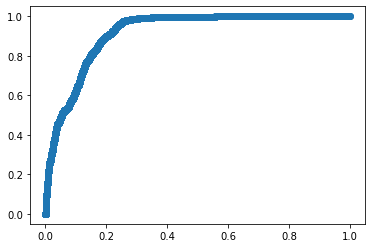

In [89]:
confuse_mat_RF

fpr, tpr, thresholds = ROC_RF

plt.scatter(1-tpr, 1-fpr)

In [74]:
RFC.score(X,Y)

0.877498001598721

### Dimension reduction for feature extraction.


It turns out that the random forest actually performs worse than the decision tree. Does that mean there are some really important features, and random forests tend to miss that? Can we do some feature selection first?

To do this, we may first apply dimension reduction with partial least square (PLS) on the data before applying random forest. We can also see if the same thing works for decision trees.

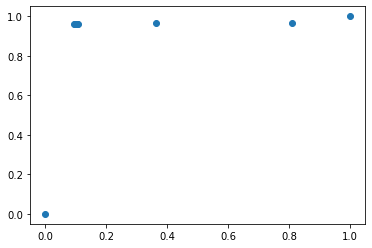

In [85]:
fpr, tpr, thresholds = ROC_result

plt.scatter(1-tpr, 1-fpr)

In [105]:
def tree_depth_testing(X,Y, test_df, num_of_samples, target_var, scaler, min_depth, max_depth):
    xx = list(range(min_depth, max_depth+1))
    acc = []
    fnr = []
    auc = []
    
    for dep in xx:
        DTC = DecisionTreeClassifier(max_depth = dep)
        DTC.fit(X,Y)
        
        confuse_mat, ROC_result, auc_dep = seqTesting(test_data, num_of_samples, 'is_fraud', scaler, DTC)
        
        acc.append((confuse_mat[0,0]+confuse_mat[1,1])/np.sum(confuse_mat))
        
        fnr.append(confuse_mat[1,0]/(confuse_mat[1,0]+ confuse_mat[1,1]))
        
        auc.append(auc_dep)
        
        print('Finished testing for depth {}.'.format(dep))
    
    
    return xx, acc, fnr, auc
    

In [109]:
xx, acc, fnr, auc = tree_depth_testing(X, Y, test_data, num_of_samples, 'is_fraud', scaler, 5, 20)

Accuracy: 0.9334321842513933
Finished testing for depth 5.
Accuracy: 0.9421830097585291
Finished testing for depth 6.
Accuracy: 0.9325648394242414
Finished testing for depth 7.
Accuracy: 0.936739611206383
Finished testing for depth 8.
Accuracy: 0.9442398046494721
Finished testing for depth 9.
Accuracy: 0.9441786226492166
Finished testing for depth 10.
Accuracy: 0.9467518656011401
Finished testing for depth 11.
Accuracy: 0.948232829901443
Finished testing for depth 12.
Accuracy: 0.9502752290276201
Finished testing for depth 13.
Accuracy: 0.950088084085662
Finished testing for depth 14.
Accuracy: 0.9511803627372827
Finished testing for depth 15.
Accuracy: 0.9524147995659676
Finished testing for depth 16.
Accuracy: 0.9532695480989493
Finished testing for depth 17.
Accuracy: 0.9528934587444374
Finished testing for depth 18.
Accuracy: 0.9579445727067097
Finished testing for depth 19.
Accuracy: 0.9573165574687926
Finished testing for depth 20.


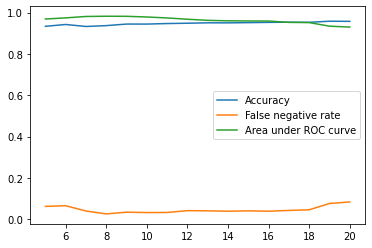

In [110]:
line_acc, = plt.plot(xx, acc)
line_acc.set_label('Accuracy')

line_fnr, = plt.plot(xx, fnr)
line_fnr.set_label('False negative rate')

line_auc, = plt.plot(xx, auc)
line_auc.set_label('Area under ROC curve')

plt.legend()

Text(0.5, 1.0, 'Testing accuracy and Area under ROC wrt maximum depth of decision tree.')

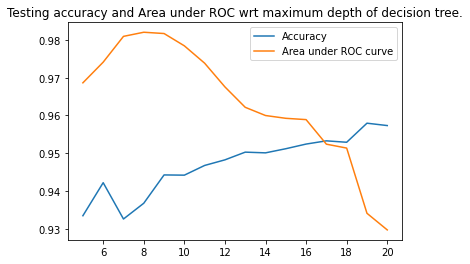

In [114]:
line_acc, = plt.plot(xx, acc)
line_acc.set_label('Accuracy')


line_auc, = plt.plot(xx, auc)
line_auc.set_label('Area under ROC curve')

plt.legend()
plt.title('Testing accuracy and Area under ROC wrt maximum depth of decision tree.')

line_fnr, = plt.plot(xx, fnr)
line_fnr.set_label('False negative rate')

plt.legend()
plt.title('False negative rate wrt maximum depth of decision tree.')

In [135]:
DTC = DecisionTreeClassifier(max_depth = 8)

DTC.fit(X,Y)

num_of_samples = 100000

confuse_mat_8, ROC_result_8, auc = seqTesting(test_data, num_of_samples, 'is_fraud', scaler, DTC)

Accuracy: 0.935375612494804


In [137]:
confuse_mat_8


array([[5.17713e+05, 3.58610e+04],
       [5.20000e+01, 2.09300e+03]])

The ratio between the fraud and all data is 2145/(2145 + 553574) = 0.00385. Using the decision tree of depth 8, the lift is (2095/(2095+36103))/0.00385 = 14.24, a huge lift.

In [119]:
DTC = DecisionTreeClassifier(max_depth = 10)

DTC.fit(X,Y)

confuse_mat_10, ROC_result_10, auc = seqTesting(test_data, num_of_samples, 'is_fraud', scaler, DTC)

Accuracy: 0.943858316883173


In [120]:
confuse_mat_10

array([[5.22444e+05, 3.11300e+04],
       [6.90000e+01, 2.07600e+03]])

### Precision boosting.

If we choose the maximum depth of the decision tree to be 8, then the false negative rate will be very low (<3%). On the other hand, the precision (The proportion of true positives relative to all predicted positives) is a quite low (<10%) due to the highly imbalanced dataset. As we have not utilized the past transaction behaviors, I am interested in investigating whether this additional piece of information can help us.

What we shall do is to first employ the decision tree. If the model flags the transaction as fradulent, then we compare this transaction with previous transactions made on the same credit card. If the transaction is actually in line with previous purchases, then that transaction will be unflagged.

How to define anomaly? My first thought is to calculate the embedded distance with the mean and flag if the distance is X times larger than the standard error.

In [45]:
train_cc = train_data.cc_num.unique()
test_cc = train_data.cc_num.unique()

print(len(train_cc), len(test_cc))

print(len(set(train_cc).intersection(set(test_cc))))

983 983
983


It can be seen that the set of credit cards are the same for training and testing data. This will greatly benefit us in our precision boosting task.

In [158]:
train_cc_fraud = train_data[train_data['is_fraud'] == 1].cc_num.unique()
test_cc_fraud = test_data[test_data['is_fraud'] == 1].cc_num.unique()

print(len(train_cc_fraud), len(test_cc_fraud))

print(len(set(train_cc_fraud).intersection(set(test_cc_fraud))))

762 218
4


In [126]:
def seqTestingWithPrecBoost(train_df, test_df, num_of_samples, target_var, scaler, model):
    '''
    This function generalizes the sequential testing function seqTesting by adding the precision boosting procedure.
    
    After producing the initial guess with the model, if the prediction flags this transaction as fraudulent, we re-examine this transaction 
    to check if the behavior is in line with the previous ones.
    
    If the transaction is not too far away from the average behavior, then we un-flag the transaction. We measure by the standard error.
    
    To suppress the false negative rate, we can start by being very conservative. Let's say it only gets unflagged for less than 
    0.5 standard error apart.
    
    '''
    
    # We start by calculating the mean and standard error with respect to the cc_num
    
    mean_dict = {}
    std_dict = {}
    
    database = train_df[['cc_num','amt', 'merch_lat', 'merch_long']]
    
    counter = 0
    
    for cc in list(train_df.cc_num.unique()):
        cc_df = database[database['cc_num'] == cc]
        
        cc_mean = cc_df.mean(axis = 0)
        cc_std = cc_df.std(axis = 0)
        
        
        mean_dict[cc] = (cc_mean['amt'], cc_mean['merch_lat'], cc_mean['merch_long'])
        std_dict[cc] = (cc_std['amt'], cc_std['merch_lat'], cc_std['merch_long'])

        counter += 1
        if counter % 100 == 0:
            print(counter)
    
    
    
    confuse_mat = np.zeros((2,2))
    
    prediction = []
    
    tot_rows = test_df.shape[0]
    
    num_of_samples = min(num_of_samples, tot_rows)
    
    for i in range(tot_rows // num_of_samples):
        
        print("Starting at data point {}".format(i*num_of_samples))
        
        sub_test = test_df.iloc[i*num_of_samples: (i+1)*num_of_samples, :]

        
        X_test = sub_test.drop(columns = [target_var, 'cc_num'])

        Y_test = sub_test[target_var]
        CC_test = sub_test['cc_num']
        
        X_test = scaler.transform(X_test)
        
        Y_predict = model.predict(X_test)
        
        for j, pred in enumerate(list(Y_predict)):
            if pred == 0:
                continue
            
            cc, amt, lat, lng = sub_test.iloc[j]['cc_num'], sub_test.iloc[j]['amt'], sub_test.iloc[j]['merch_lat'], sub_test.iloc[j]['merch_long']
            
            
            if cc not in mean_dict:
                print(cc)
                continue
            
            mean_amt, mean_lat, mean_lng = mean_dict[cc]
            std_amt, std_lat, std_lng = std_dict[cc]
            
            metric = ((amt - mean_amt)/std_amt)**2 + ((lat - mean_lat)/std_lat)**2 + ((lng - mean_lng)/std_lng)**2
            
            if metric < 1:
                Y_predict[j] = 0
        
        
        Y_prob = model.predict_proba(X_test)[:,1]
        
        confuse_mat += confusion_matrix(Y_test, Y_predict)
        
        prediction += list(Y_prob)
    
    sub_test = test_df.iloc[(tot_rows // num_of_samples)*num_of_samples:, :]
    X_test = sub_test.drop(columns = [target_var, 'cc_num'])
    Y_test = sub_test[target_var]
    CC_test = sub_test['cc_num']
    
    
    X_test = scaler.transform(X_test)
        
    Y_predict = model.predict(X_test)
    
    Y_prob = model.predict_proba(X_test)[:,1]

    for j, pred in enumerate(list(Y_predict)):
        if pred == 0:
            continue
            
        cc, amt, lat, lng = sub_test.iloc[j]['cc_num'], sub_test.iloc[j]['amt'], sub_test.iloc[j]['merch_lat'], sub_test.iloc[j]['merch_long']
            
            
        if cc not in mean_dict:
            print(cc)
            continue
            
        mean_amt, mean_lat, mean_lng = mean_dict[cc]
        std_amt, std_lat, std_lng = std_dict[cc]
            
        metric = ((amt - mean_amt)/std_amt)**2 + ((lat - mean_lat)/std_lat)**2 + ((lng - mean_lng)/std_lng)**2
            
        if metric < 1:
            Y_predict[j] = 0
    
    
    prediction += list(Y_prob)
    
    confuse_mat += confusion_matrix(Y_test, Y_predict)
    
    
    ROC_result = roc_curve(test_df[target_var], np.array(prediction))
    
    auc = roc_auc_score(test_df[target_var], np.array(prediction))
    
    
    print('Accuracy: {}'.format((confuse_mat[0,0]+confuse_mat[1,1])/np.sum(confuse_mat)))
    
    
    return confuse_mat, ROC_result, auc

In [127]:
confuse_mat, _, _ = seqTestingWithPrecBoost(train_data, test_data, num_of_samples, 'is_fraud', scaler, DTC)

100
200
300
400
500
600
700
800
900
Starting at data point 0
180098888332620
180098888332620
180098888332620
180098888332620
180098888332620
180098888332620
180098888332620
180098888332620
180098888332620
180098888332620
180098888332620
3540416671210051
3540416671210051
3540416671210051
3540416671210051
3540416671210051
3540416671210051
3540416671210051
3540416671210051
503851367360
503851367360
503851367360
503851367360
503851367360
503851367360
503851367360
503851367360
503851367360
503851367360
Starting at data point 100000
4352307151555405069
4352307151555405069
4352307151555405069
4352307151555405069
4352307151555405069
4352307151555405069
4352307151555405069
Starting at data point 200000
180052752563109
180052752563109
180052752563109
180052752563109
180052752563109
180052752563109
180052752563109
180052752563109
180052752563109
180052752563109
180052752563109
180052752563109
4417677808209716
3550412175018089
4417677808209716
4417677808209716
3550412175018089
3550412175018089
355

In [104]:
train_data['cc_num'] = train_data['cc_num'].astype(str)
test_data['cc_num'] = test_data['cc_num'].astype(str)

In [128]:
confuse_mat

array([[5.2355e+05, 3.0024e+04],
       [1.4600e+02, 1.9990e+03]])

In [125]:
test_data.groupby(['is_fraud']).count()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,merchant_fraud_Abbott-Rogahn,...,job_Visual merchandiser,job_Volunteer coordinator,job_Warden/ranger,job_Waste management officer,job_Water engineer,job_Water quality scientist,job_Web designer,job_Wellsite geologist,job_Writer,job_others
is_fraud,,,,,,,,,,,,,,,,,,,,,
0,553574,553574,553574,553574,553574,553574,553574,553574,553574,553574,...,553574,553574,553574,553574,553574,553574,553574,553574,553574,553574
1,2145,2145,2145,2145,2145,2145,2145,2145,2145,2145,...,2145,2145,2145,2145,2145,2145,2145,2145,2145,2145


In [129]:
train_data.shape

(1296675, 1195)

In [132]:
confuse_mat_LR, ROC_result_LR, auc = seqTesting(test_data, num_of_samples, 'is_fraud', scaler, LR)

Accuracy: 0.8838891598091841


In [133]:
confuse_mat_LR

array([[489948.,  63626.],
       [   899.,   1246.]])